In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

## Introduction

Ce notebook vise à présenter l'évolution d'un TVAR(2) en fonction du choix de T qui définit l'intervalle entre deux mesures du processus sur l'intervalle [0,1].

Rappelons que nous définissons le TVAR(2) comme suit $\forall t$ dans $[0,1]$:

\begin{equation}
X_{t,T} = a_1(\frac{t}{T})X_{t-1,T} + a_2(\frac{t}{T})X_{t-2,T} + \sigma(\frac{t}{T})\epsilon_{t,T}
\end{equation}

Avec $\epsilon_{t,T}$ un bruit blanc centré de variance 1.
Dans la suite, pour simplifier les expressions, on prendra $\sigma(u)=1$ sur $[0,1]$.

## Premier exemple : racines réelles

Prenons le polynôme caractéristique avec $\forall u$ dans $[0,1]$:
    \begin{equation}
    A(z;u) = 1 - a_1(u) z - a_2(u) z^2
    \end{equation}

Pour le cas $p=2$, il est facile de choisir des coefficients pour le TVAR puisqu'on a les relations coefficients/racines suivantes lorsque l'on note $z_1$ et $z_2$ les racines du polynome $az^2 + bz + 1$:
\begin{equation}
a = \frac{1}{z_1 z_2}
\end{equation}
\begin{equation}
b = -\frac{z_1 + z_2}{z_1 z_2}
\end{equation}

Donc en choisissant les racines variant au cours du temps $u$ dans $[0,1]$ $z_1(u) =  2 + u$ et $z_2(u) = 5 + \sin(2 \pi u)$ (on vérifie bien la condition que $|z| > 1$), on a les coefficients : 

\begin{equation}
a_1(u) = -\frac{(7 + u+ \sin(2\pi u))}{(2 + u)(5 +\sin(2 \pi u))}
\end{equation}
\begin{equation}
a_2(u) = \frac{1}{(2 + u)(5 + \sin(2 \pi u))}
\end{equation}

In [2]:
epsilon = np.random.randn(int(2e4))

### T = 100

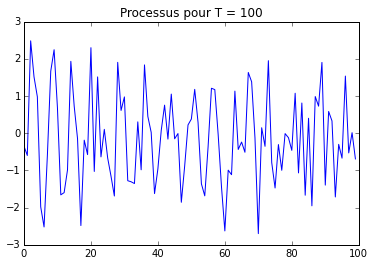

In [3]:
T = 100
X = np.zeros(2*T)
a_1 = np.zeros(2*T)
a_2 = np.zeros(2*T)

u = np.arange(T, dtype='double')/T

a_2[T:2*T] = 1. / ((2 + u) * (5 + np.sin(2 * np.pi * u)))
a_1[T:2*T] = - (7 + u + np.sin(2 * np.pi * u)) * a_2[T:2*T]
    
X[0] = epsilon[0]
X[1] = epsilon[100]
    
for n in np.arange(2*T-2):
    X[n+2] = a_1[n+2]*X[n-1] + a_2[n+2]*X[n-2] + epsilon[(n+2)*100]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], X[T:2*T])
plt.title("Processus pour T = 100")

### T = 1000

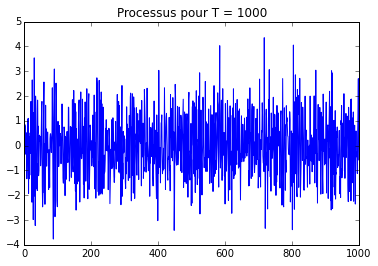

In [4]:
T = 1000
X = np.zeros(2*T)
a_1 = np.zeros(2*T)
a_2 = np.zeros(2*T)

u = np.arange(T, dtype='double')/T

a_2[T:2*T] = 1. / ((2 + u) * (5 + np.sin(2 * np.pi * u)))
a_1[T:2*T] = - (7 + u + np.sin(2 * np.pi * u)) * a_2[T:2*T]
    
X[0] = epsilon[0]
X[1] = epsilon[10]
    
for n in np.arange(2*T-2):
    X[n+2] = a_1[n+2]*X[n-1] + a_2[n+2]*X[n-2] + epsilon[(n+2)*10]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], X[T:2*T])
plt.title("Processus pour T = 1000")

### T = 10000

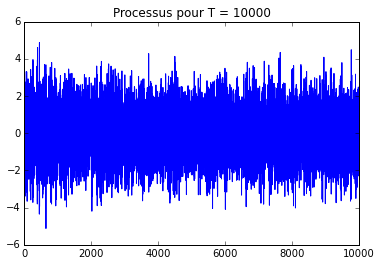

In [5]:
T = 10000
X = np.zeros(2*T)
a_1 = np.zeros(2*T)
a_2 = np.zeros(2*T)

u = np.arange(T, dtype='double')/T

a_2[T:2*T] = 1. / ((2 + u) * (5 + np.sin(2 * np.pi * u)))
a_1[T:2*T] = - (7 + u + np.sin(2 * np.pi * u)) * a_2[T:2*T]
    
X[0] = epsilon[0]
X[1] = epsilon[1]
    
for n in np.arange(2*T-2):
    X[n+2] = a_1[n+2]*X[n-1] + a_2[n+2]*X[n-2] + epsilon[n+2]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], X[T:2*T])
plt.title("Processus pour T = 10000")

### Deuxième exemple : racines complexes conjuguées 

On s'intéresse maintenant au cas où les racines que l'on recherche sont complexes conjuguées.

Si on note $r = r_1 + ir_2$ l'une des deux racines, on a par les relations coefficients/racines que:
\begin{equation}
a = \frac{1}{|r|^2}
\end{equation}
\begin{equation}
b = - 2\frac{Re(r)}{|r|^2}
\end{equation}

Avec $r = \frac{1}{2} + i\frac{1}{10}$, on a 

### T = 100

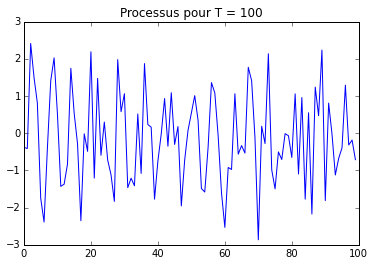

In [6]:
T = 100
X = np.zeros(2*T)
a_1 = np.zeros(2*T)
a_2 = np.zeros(2*T)


u = np.arange(T, dtype='double')/T
r = (3-u + (1+0.5*u)*1j) * np.ones(T)

a_2[T:2*T] = 1. / abs(r) ** 2
a_1[T:2*T] = - 2 * np.real(r) * a_2[T:2*T]
    
X[0] = epsilon[0]
X[1] = epsilon[100]
    
for n in np.arange(2*T-2):
    X[n+2] = a_1[n+2]*X[n-1] + a_2[n+2]*X[n-2] + epsilon[(n+2)*100]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], X[T:2*T])
plt.title("Processus pour T = 100")

### T = 1000

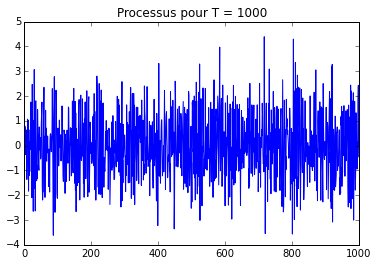

In [7]:
T = 1000
X = np.zeros(2*T)
a_1 = np.zeros(2*T)
a_2 = np.zeros(2*T)


u = np.arange(T, dtype='double')/T
r = (3-u + (1+0.5*u)*1j) * np.ones(T)

a_2[T:2*T] = 1. / abs(r) ** 2
a_1[T:2*T] = - 2 * np.real(r) * a_2[T:2*T]
    
X[0] = epsilon[0]
X[1] = epsilon[10]
    
for n in np.arange(2*T-2):
    X[n+2] = a_1[n+2]*X[n-1] + a_2[n+2]*X[n-2] + epsilon[(n+2)*10]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], X[T:2*T])
plt.title("Processus pour T = 1000")

### T = 10000

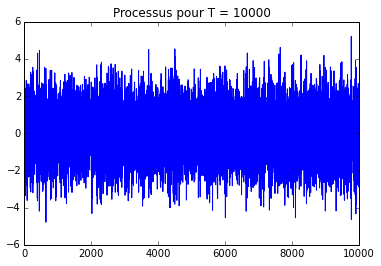

In [8]:
T = 10000
X = np.zeros(2*T)
a_1 = np.zeros(2*T)
a_2 = np.zeros(2*T)


u = np.arange(T, dtype='double')/T
r = (3-u + (1+0.5*u)*1j) * np.ones(T)

a_2[T:2*T] = 1. / abs(r) ** 2
a_1[T:2*T] = - 2 * np.real(r) * a_2[T:2*T]
    
X[0] = epsilon[0]
X[1] = epsilon[1]
    
for n in np.arange(2*T-2):
    X[n+2] = a_1[n+2]*X[n-1] + a_2[n+2]*X[n-2] + epsilon[n+2]
    
t = np.arange(2*T) - T #horizon des temps

plt.plot(t[T:2*T], X[T:2*T])
plt.title("Processus pour T = 10000")

# TODO 2/06

Trovuer les coefficients qui vont bien :
- relations coefficients racine
- algo de levinson pour trouver les coefficients AR à partir des coefficients de corrélation (relations par récurrence, avec des coeff causaux, continus... ; trouver $\kappa=f(\Phi)$)

Dans le cas de levinson, prendre une matrice de correaltion et pas d'autocovariance pour assurer la stabilité.

Trouver une implémentation de $\hat\theta$ et de sa DSP en fonction de $\lambda$ et de $t$.

Faire une simulation avec des coeff complexes conjugués avec animation de la DSP. La puissance se trouve là où $\lambda$ = angle($\phi$).

Trouver ensuite sur les exemples le comportement de $\mu$ (terme de variance dans le théorème 2) et comprendre son influence.

### Génération de TVAR par algorithme de Levinson-Durbin

On va maintenent se servir d'un géné d'AR puis de TVAR à partir des équations de Yule et Walker ainsi que de l'algorithme de Levinson - Durbin.

Pour se faire, on génère des matrice de corrélation pour chaque échantillon de $X_t$ puis on trovue les prédicteurs associés. Prendre une matrice de corrélations et non de convariances assure que le polynome caractéristique du processus obtenu est bien celui d'un processus AR/TVAR stable.


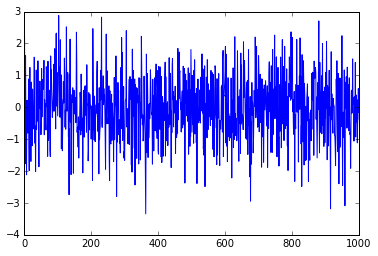

In [29]:
from scipy.linalg import toeplitz, pinv

def generation_TVAR(d, T, epsilon):
    """ generation d'un vecteur de taille 2T dont le zéro se situe à l'indice T"""
    X = epsilon
    theta = np.matrix(np.zeros((d+1, T)))
    
    for t in np.arange(T):
        gamma = 100 * np.random.rand(d+1) - 200 #prend des valeurs entre -100 et 100
        Gamma = np.matrix(toeplitz(gamma))
        
        L = np.matrix(np.zeros((d+1,1)))
        L[0,0] = 1
        
        theta[:,t] = - pinv(Gamma) * L
                
        #theta[:,t] = theta[:,t] / abs(theta[0,t])
        
        X[T + t] = np.dot(X[T+t-d:T+t][::-1], theta[1:,t]) + epsilon[T + t] 
        
    return X, theta[1:,:]

# test 
T = 1000
d = 1
epsilon = np.random.randn(2*T)

X, theta = generation_TVAR(d, T, epsilon)

plt.plot(X[T:])

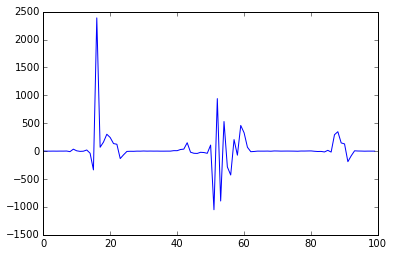

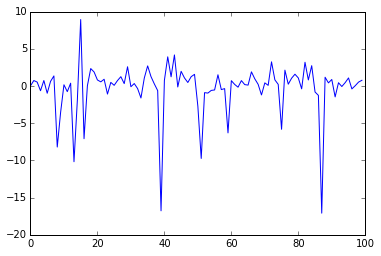

In [36]:
def generation_TVAR_bis(d, T, epsilon):
    """ generation d'un vecteur de taille 2T dont le zéro se situe à l'indice T
        par une génération plus fine de la matrice de covariance.
        On prend en compte les coefficients d'avant"""
    
    X = epsilon
    theta = np.matrix(np.zeros((d+1, T)))
    
    Gamma = np.eye(d+1) # matrice d'autocorrelation d'ordre d+1 pour t < 0 où X = epsilon
    
    for t in np.arange(T):
        gamma = 0.2 * np.random.rand(d+1) - 0.1 #On génère de nouvelles correlations entre -1 et 1
                                            # Elles correspondent aux E[X(t)X(t-i)] pour i = 0...d          
        Gamma_new = np.zeros((d+1,d+1))
        Gamma_new[1:,1:] = Gamma[:-1,:-1]
        Gamma_new[0,:] = gamma
        Gamma_new[1:,0] = gamma[1:]     
        Gamma = Gamma_new
      
        L = np.matrix(np.zeros((d+1,1)))
        L[0,0] = 1

        theta[:,t] = - pinv(Gamma) * L      
        theta[:,t] = theta[:,t] / abs(theta[0,t])        
              
        X[T + t] = np.dot(X[T+t-d:T+t][::-1], theta[1:,t]) + epsilon[T + t] 
        
    return X, theta

T = 100
p = 1
epsilon = np.random.randn(2*T)

X, theta = generation_TVAR_bis(p, T, epsilon)

plt.plot(np.arange(T),X[T:])
plt.figure(2)
plt.plot(np.arange(T),theta[1,:].T)

# Construction de l'estimateur

Dans cette partie, on cherche à construire un estimateur du vecteur $\theta_T$ qui contient les coefficients du polynome caractéristique du processus TVAR pour une fenêtre d'observation des échantillons de période $T$.

Pour ce faire, on le construit grâce à un algorithme en ligne de type NLMS avec un pas de descente de gradient de $\mu$.

In [11]:
from scipy.linalg import norm

def generation_est(X, d, T, mu):

    theta_est = np.matrix(np.zeros((d,T)))
    X_est = np.zeros(T)
    
    for k in (np.arange(T)): # on fait T itérations
        XX = X[T+k-d:T+k][::-1]
        
        if k==0:
            theta_est[:,k] = np.matrix(mu * X[T+k] * XX / (1 + mu * norm(XX) ** 2)).T 
        else:
            theta_est[:,k] = np.matrix(theta_est[:,k-1].T + mu * (X[T+k] - np.dot(XX, theta_est[:,k-1])) * XX / (1 + mu * norm(XX) ** 2)).T  

        X_est[k] = np.dot(XX, theta_est[:,k])
        
    return X_est, theta_est

On va maintenant calculer la DSP du processus réel $X_t$ déterminé par l'algorithme de Levinson-Durbin ainsi que celle du processus estimé $\hat X_t$ obtenu à partir de $\hat\theta_n$.

In [12]:
from scipy.fftpack import fft

def dsp(theta, T, N = 512):
    dsp_array = np.matrix(np.zeros((N, T)))
    
    for t in np.arange(T):
        dsp_array[:,t] = np.matrix(1./abs(fft(theta[:,t].T, N)) ** 2).T
        
    return dsp_array

### Influence du paramètre $\mu$

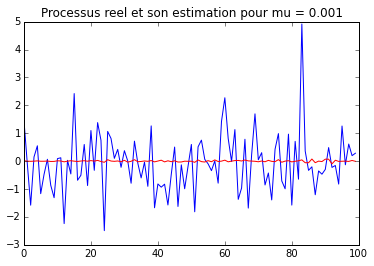

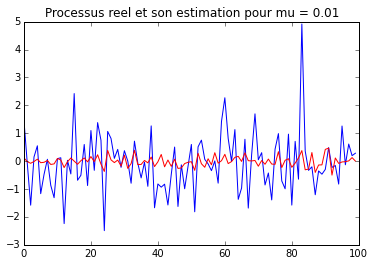

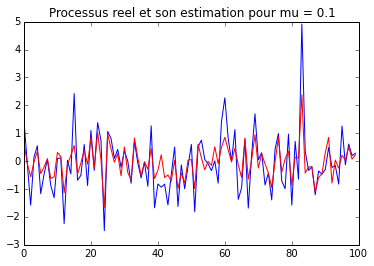

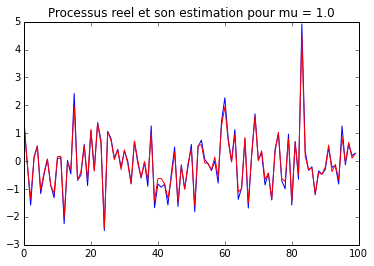

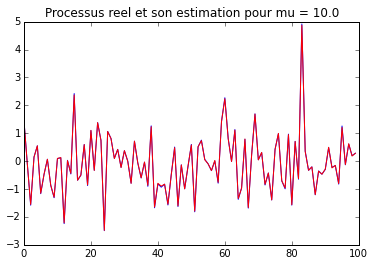

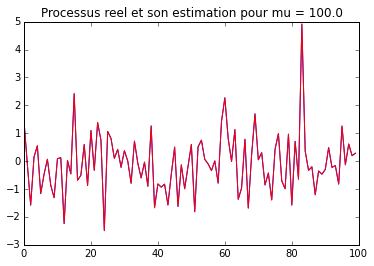

In [13]:
log_mu = np.arange(-3, 3, 1, dtype='double')
mu_array = np.power(10, log_mu)

d = 10
T = int(1e2)
epsilon = np.random.randn(2*T)

X, theta = generation_TVAR(d, T, epsilon)

for mu in mu_array:
    
    X_est, theta_est = generation_est(X, d, T, mu)

    plt.figure()
    plt.plot(X[T:], 'b', label = 'X')
    plt.plot(X_est, 'r', label = 'X_est')
    plt.title("Processus reel et son estimation pour mu = {}".format(mu))

Comme on s'en doutait, la valeur de $\mu$ influe sur la qualité de l'estimateur. Dans cet exemple, pour des valeur du pas qui sont petites, le gradient n'arrive pas à suivre les variations du processus $X_{t,T}$ donc on n'obserbe que de petites variations autour de 0. Dès que le pas est plus grand, on fait d'assez grands sauts pour suivre les variations du processus.

Le fait de prendre un pas très grand n'est pas un problème ici car on a pris le NLMS et pas simplement le LMS. Le fait de normaliser permet d'adapter le pas en fonction de la norme de l'échantillon étudié. Cependant si $\mu$ est trop petit, l'importance de la norme et de $X_{t-1, T}$ et de $X_{(t_l, 0<l<d+1),T}$ n'est pas prise en compte.

### Exemple 1 : un TVAR(d) quelconque

[-7.56421996  7.30498295]


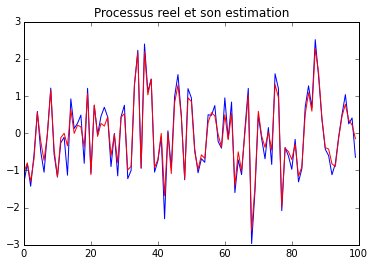

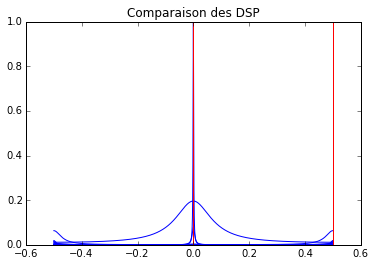

In [20]:
d = 2
T = int(1e2)
mu = 5e-0 #d=2 -> mu = 1, d=10 -> mu = 0.5
epsilon = np.random.randn(2*T)

X, theta = generation_TVAR(d, T, epsilon)
X_est, theta_est = generation_est(X, d, T, mu)

plt.figure()
plt.plot(X[T:], 'b', label = 'X')
plt.plot(X_est, 'r', label = 'X_est')
plt.title("Processus reel et son estimation")

N = 2**15

dsp_X = dsp(theta, T, N)
dsp_X_est = dsp(theta_est, T, N)

coeffs = np.ones(d+1)
coeffs[1:] = theta[:,0].T
roots = np.roots(coeffs[::-1])
print(roots)
angles = np.angle(roots) / (2 * np.pi)
        

lambd = np.arange(-N/2, N/2, 1, dtype = 'double') / N

plt.figure()
#plt.plot(lambd, dsp_X/np.max(abs(dsp_X)), 'b', label ='vraie DSP')
plt.plot(lambd, dsp_X_est/np.max(abs(dsp_X_est)), 'b', label = 'DSP estimee')

for k in np.arange(d):
    plt.axvline(x=angles[k], ymin=0, ymax=1, linewidth=1, color = 'r')
plt.title("Comparaison des DSP")

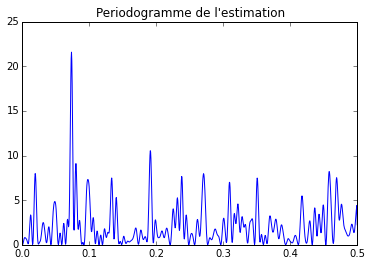

In [27]:
from scipy.signal import periodogram

M = 2048

f, Pxx = periodogram(X, nfft = M)

plt.plot(f, Pxx, 'b')
for k in np.arange(d):
    if angles[k] >= 0:
        plt.axvline(x=angles[k], ymin=0, ymax=1, linewidth=1, color = 'r')
plt.title("Periodogramme de l'estimation")

### Exemple 2 : "a-e-i-o-u"

On sait que les phonèmes sont modélisables par des processus AR. On va voir si le TVAR s'adapte bien aux changements de lettres dans "aeiou".

0.000462638755442


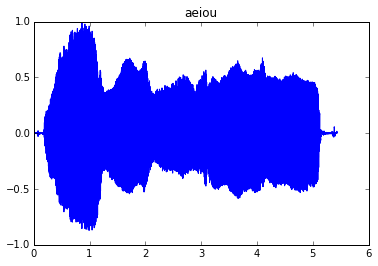

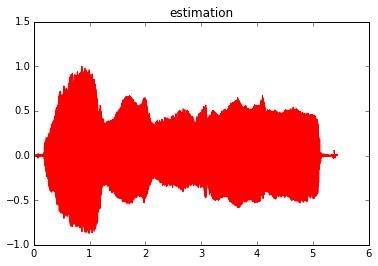

In [15]:
from scipy.io.wavfile import *
import IPython


Fs, X = read("data/aeiou.wav")
X = np.float64(X)

d = 2 #On se donne un TVAR long quitte à avoir certains coefficients nuls à la fin
T = len(X)
mu = 1e-2
temp = np.random.randn(2*T)
temp[T:] = X #on ajoute du bruit au début pour simuler le silence au début de la trame

X_est, theta_est = generation_est(temp, d, T, mu)

max_X = abs(max(X))
t = np.arange(T, dtype = "double")/Fs
plt.figure()
plt.plot(t, X/max_X, 'b', label="aeiou")
plt.title("aeiou")

plt.figure()
plt.plot(t, X_est/max_X, 'r', label="estimation")
plt.title("estimation")

print(norm((X - X_est)/max_X) ** 2)

#write('data/out.wav', Fs, X_est)
IPython.display.Audio(X_est, rate=Fs)

0.00161626748677


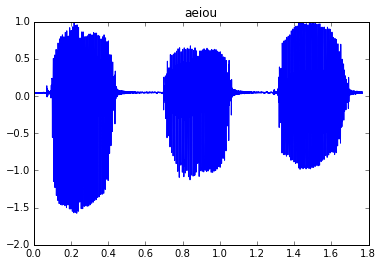

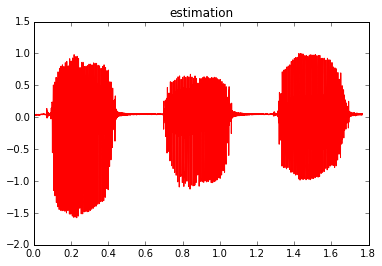

In [28]:
Fs, X = read("data/an_in_on.wav")
X = np.float64(X)

d = 2 #On se donne un TVAR long quitte à avoir certains coefficients nuls à la fin
T = len(X)
mu = 1e-2
temp = np.random.randn(2*T)
temp[T:] = X #on ajoute du bruit au début pour simuler le silence au début de la trame

X_est, theta_est = generation_est(temp, d, T, mu)

max_X = abs(max(X))
t = np.arange(T, dtype = "double")/Fs
plt.figure()
plt.plot(t, X/max_X, 'b', label="aeiou")
plt.title("aeiou")

plt.figure()
plt.plot(t, X_est/max_X, 'r', label="estimation")
plt.title("estimation")

print(norm((X - X_est)/max_X) ** 2)
